# Pipelines Zoo for visual grounding

This notebbok contains all implemented pipelines to perform visual grounding. Its purpose is to showcase and quickly experiment with the different pipelines.

## Preliminary steps

In [2]:
# Import necessary modules

import matplotlib.pyplot as plt
import numpy as np

from modules.pipelines.clipseg import ClipSeg
from modules.pipelines.detrclip import DetrClip
from modules.pipelines.yoloclip import YoloClip
from modules.pipelines.clipssd import ClipSSD
from modules.pipelines.mdetr import MDETRvg
from modules.refcocog import RefCOCOg, RefCOCOgSample
from modules.utilities import get_best_device, visual_grounding_test

%matplotlib inline


In [3]:
# Set the best device according to the machine running the notebook.

device = get_best_device()


[INFO] Using MPS.


In [6]:
# Import the RefCOCOg dataset and create train/validation/test splits

data_path = "dataset/refcocog"

dataset = RefCOCOg(ds_path=data_path)

train_ds = RefCOCOg(ds_path=data_path, split='train')
val_ds = RefCOCOg(ds_path=data_path, split='val')
test_ds = RefCOCOg(ds_path=data_path, split='test')

print(f"[INFO] Dataset Size: {len(dataset)}")
print(f"[INFO] train split:  {len(train_ds)}")
print(f"[INFO] val split:    {len(val_ds)}")
print(f"[INFO] test split:   {len(test_ds)}")


[INFO] Dataset Size: 49822
[INFO] train split:  42226
[INFO] val split:    2573
[INFO] test split:   5023


## The pipelines

First, we initialize the pipelines.

In [5]:
# YOLOv5 + CLIP
yolo5clip = YoloClip(dataset.categories, yolo_ver="yolov5su", quiet=True, device=device)

# YOLOv8 + CLIP
yolo8clip = YoloClip(dataset.categories, yolo_ver="yolov8x", quiet=True, device=device)

# Watershed seg. + CLIP | pooling maps with 4, 8, 16, 32 segments | filtering below 0.75 q.tile
wshedclip = ClipSeg(dataset.categories, method="w", n_segments=(4, 8, 16, 32), q=0.75, quiet=False, device=device)

# SLIC seg. + CLIP | pooling maps with 4, 8, 16, 32 segments | filtering below 0.75 q.tile
slicnclip = ClipSeg(dataset.categories, method="s", n_segments=(4, 8, 16, 32), q=0.75, quiet=False, device=device)

# SSD + CLIP | with 0.01 confidence
ssdnclip = ClipSSD(dataset.categories, confidence_t=0.01, device=device)

# DETR + CLIP
detrnclip = DetrClip(dataset.categories, quiet=True, device=device)

# MDETR for visual grounding
mdetr = MDETRvg(dataset.categories, quiet=True, device=device)


[INFO] Initializing YoloClip pipeline
[INFO] YOLO version: yolov5su

[INFO] Initializing YoloClip pipeline
[INFO] YOLO version: yolov8x

[INFO] Initializing ClipSeg pipeline
[INFO] Segmentation method: w
[INFO] Number of segments: (4, 8, 16, 32)
[INFO] Threshold q.tile for filtering: 0.75
[INFO] Downsampling factor: 16

[INFO] Initializing ClipSeg pipeline
[INFO] Segmentation method: s
[INFO] Number of segments: (4, 8, 16, 32)
[INFO] Threshold q.tile for filtering: 0.75
[INFO] Downsampling factor: 16

[ERROR] Single Shot Detector requires CUDA. Returning empty object.

[INFO] Initializing DetrClip pipeline

[INFO] Initializing MDETR pipeline



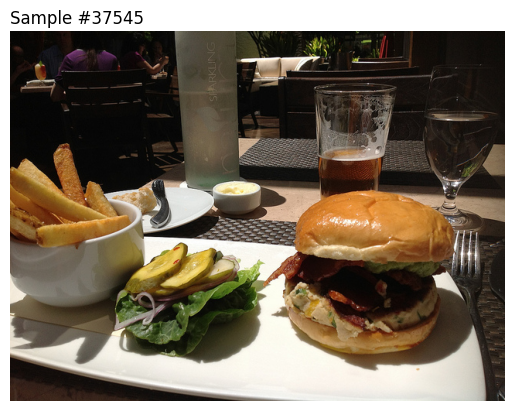

In [50]:
# Pick a random sample from the dataset

idx = np.random.randint(0, len(dataset))
sample = RefCOCOgSample(**dataset[idx])

plt.imshow(sample.img)
plt.axis("off")
plt.title(f"Sample #{idx}", loc="left")
plt.show()


### YOLOv5 + CLIP

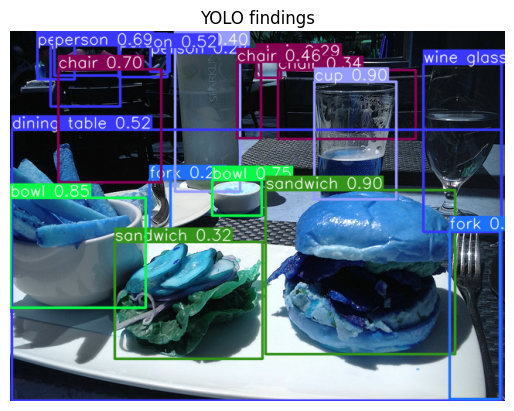

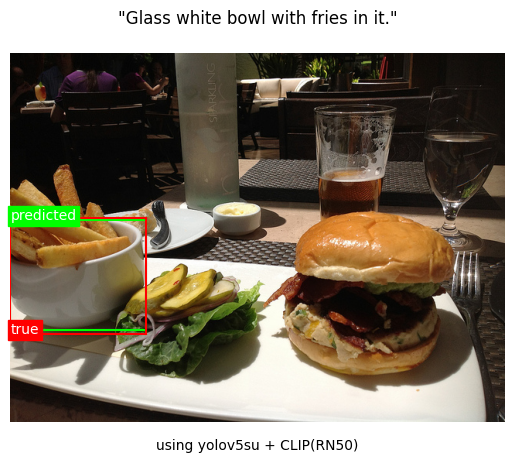

{'IoU': 0.9408271908760071,
 'cosine': 0.24947763979434967,
 'euclidean': 1.2251713275909424,
 'dotproduct': 0.24947763979434967,
 'grounding': 1.0}

In [51]:
yolo5clip(sample, sample.sentences[0], show_yolo=True, show=True, timeit=False)


### YOLOv8 + CLIP

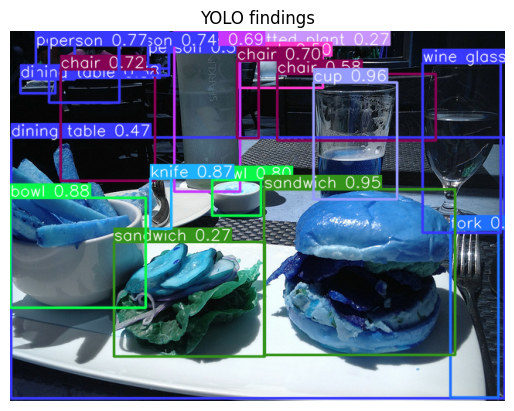

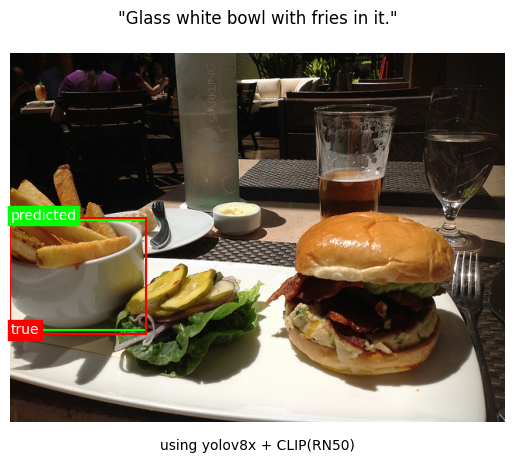

{'IoU': 0.9478825926780701,
 'cosine': 0.24212005734443665,
 'euclidean': 1.2311620712280273,
 'dotproduct': 0.24212005734443665,
 'grounding': 1.0}

In [52]:
yolo8clip(sample, sample.sentences[0], show_yolo=True, show=True, timeit=False)


### Watershed + CLIP

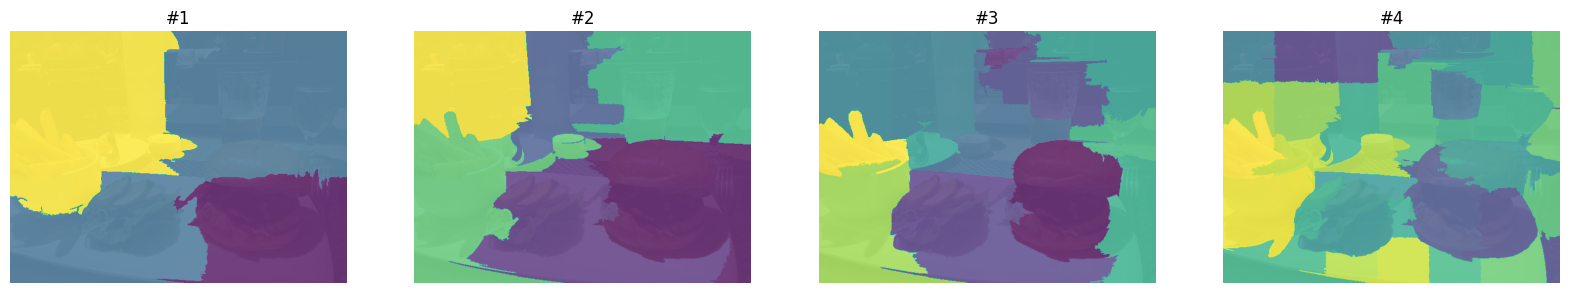

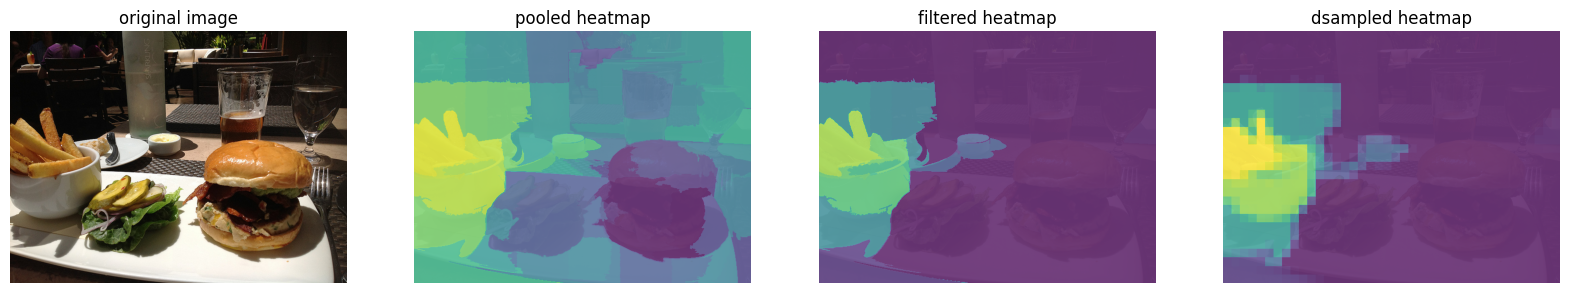

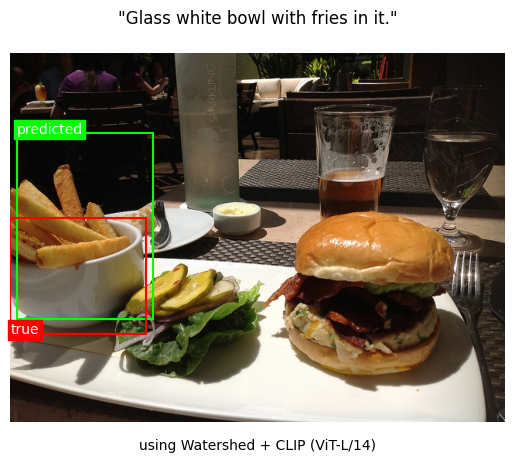

{'IoU': 0.46797576546669006,
 'cosine': 0.22239354252815247,
 'euclidean': 1.2470818758010864,
 'dotproduct': 2.826984405517578,
 'grounding': 0.0}

In [53]:
wshedclip(sample, sample.sentences[0], show_process=True, show_masks=True, show=True, timeit=False)


### SLIC + CLIP

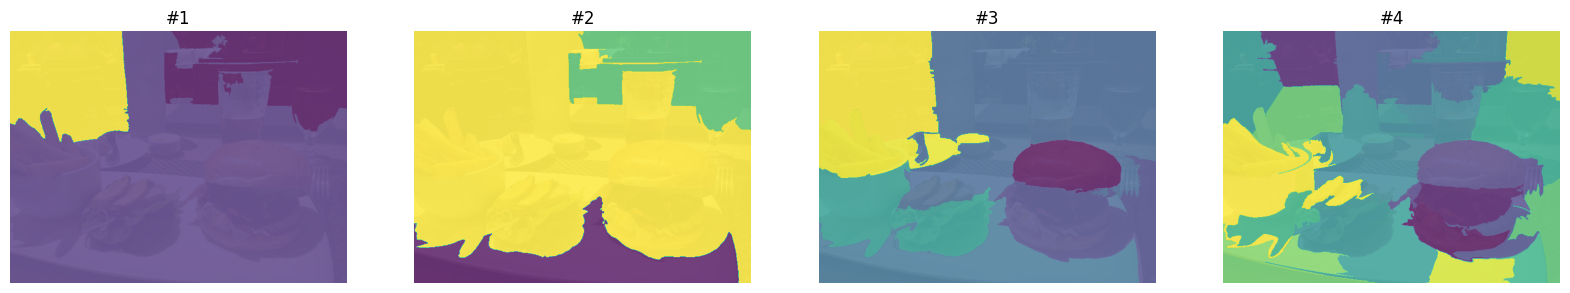

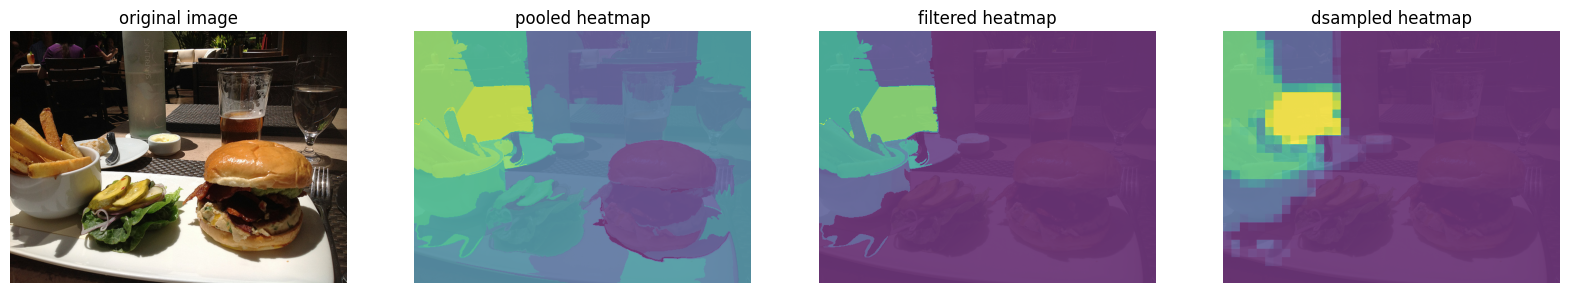

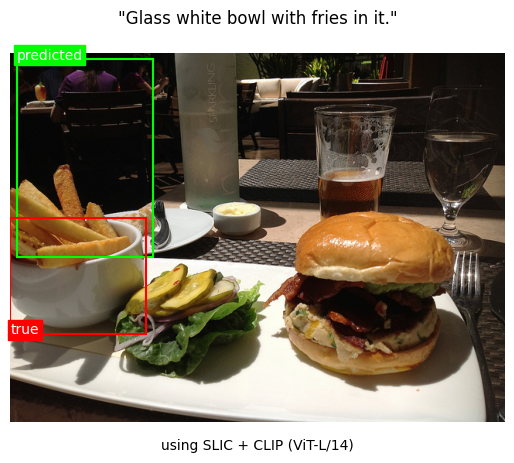

{'IoU': 0.1349528431892395,
 'cosine': 0.23348933458328247,
 'euclidean': 1.2381523847579956,
 'dotproduct': 2.9680299758911133,
 'grounding': 0.0}

In [55]:
slicnclip(sample, sample.sentences[0], show_process=True, show_masks=True, show=True, timeit=False)


### SSD + CLIP

In [18]:
ssdnclip(sample, sample.sentences[0], show=True, timeit=False)


### DETR + CLIP

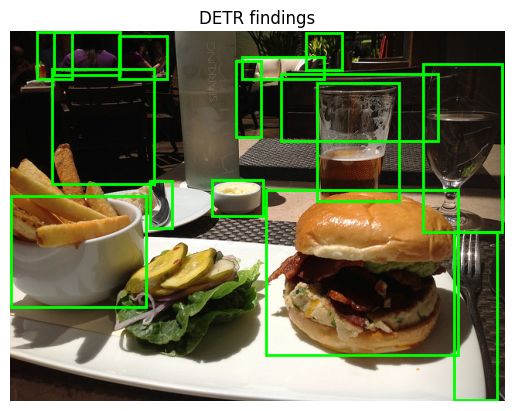

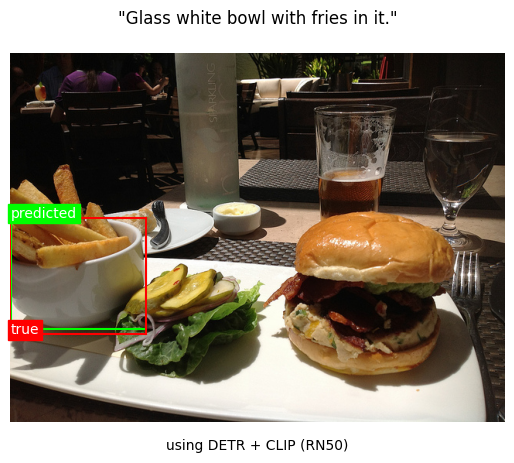

{'IoU': 0.9486685991287231,
 'cosine': 0.23422549664974213,
 'euclidean': 1.2375577688217163,
 'dotproduct': 0.23422549664974213,
 'grounding': 1.0}

In [56]:
detrnclip(sample, sample.sentences[0], show_detr=True, show=True, timeit=False)


### MDETR

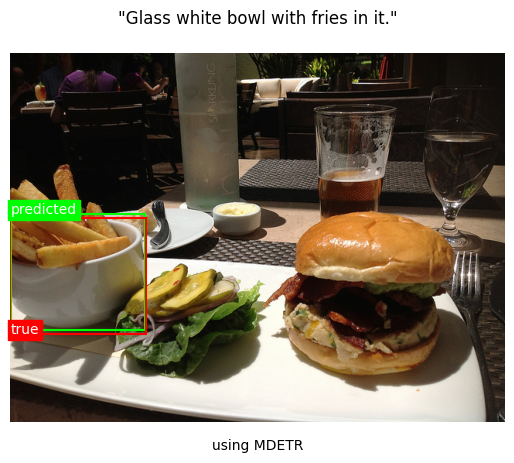

{'IoU': 0.9265148043632507,
 'cosine': 0.46714770793914795,
 'euclidean': 1.0323296785354614,
 'dotproduct': 0.46714770793914795,
 'grounding': 0.0}

In [54]:
mdetr(sample, sample.sentences[0], show=True, timeit=False)


## Testing

Here you can test a pipeline of choice on the test set.

In [22]:
pipeline = yolo5clip # yolo8clip, wshedclip, slicnclip, detrnclip, ssdnclip, mdetr

visual_grounding_test(pipeline, test_ds)
